In [2]:
# %load init.ipy
%reload_ext autoreload
%autoreload 2

import os, sys, logging
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import corner
from nose import tools

import matplotlib as mpl
import matplotlib.pyplot as plt

import kalepy as kale


In [3]:
from kalepy import utils

# Trapezoid Integration

In [4]:
from kalepy.utils import trapz_dens_to_mass

(2, 3000)
(20, 30)
True
True


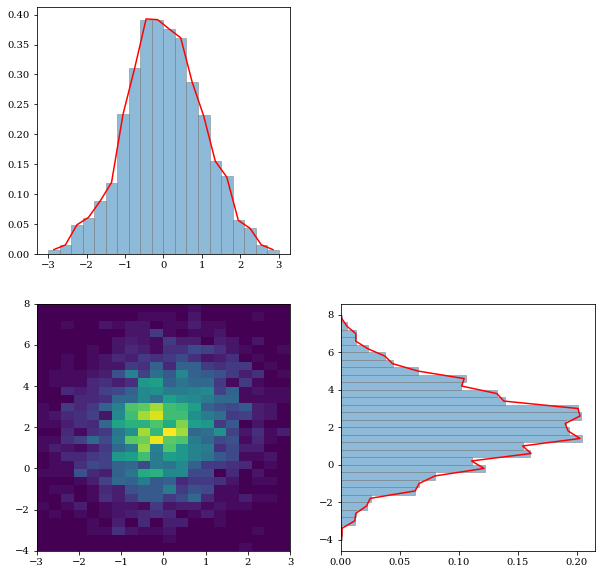

In [106]:
nbins = [20, 30]
xx = np.linspace(-3.0, 3.0, nbins[0]+1)
yy = np.linspace(-4.0, 8.0, nbins[1]+1)

xc = kale.utils.midpoints(xx, 'lin')
yc = kale.utils.midpoints(yy, 'lin')

grid = np.meshgrid(xx, yy)
zz = np.random.multivariate_normal([0.0, 2.0], [[1.0, 0.2],[0.2, 4.0]], 3000).T
print(zz.shape)

fig, axes = plt.subplots(figsize=[10, 10], ncols=2, nrows=2)
axes[0, 1].set_visible(False)
axes = [axes[1, 0], axes[0, 0], axes[1, 1]]
# axes = [ax for ii, ax in enumerate(axes.flatten()) if ii != 1]

ax = axes[0]
pdf, *_ = ax.hist2d(zz[0].flatten(), zz[1].flatten(), bins=(xx, yy), density=True)
print(pdf.shape)


ax = axes[1]
xpdf, *_ = ax.hist(zz[0].flatten(), bins=xx, density=True, alpha=0.5, edgecolor='0.5')

proj_pdf = kale.utils.trapz_nd(pdf, [xc, yc], axis=1)
print(np.allclose(xpdf, proj_pdf, rtol=1e-1))
ax.plot(xc, proj_pdf, 'r-')

ax = axes[2]
ypdf, *_ = ax.hist(zz[1].flatten(), bins=yy, orientation='horizontal', density=True, alpha=0.5, edgecolor='0.5')

proj_pdf = kale.utils.trapz_nd(pdf, [xc, yc], axis=0)
print(np.allclose(ypdf, proj_pdf, rtol=1e-1))
ax.plot(proj_pdf, yc, 'r-')

plt.show()

In [43]:
def _test_ndim_a1(ndim):
    from kalepy import utils

    BIN_SIZE_RANGE = [10, 30]
    num_bins = np.random.randint(*BIN_SIZE_RANGE, ndim)
    # num_bins = [3, 4]
    
    edges = []
    extr = []
    for nb in num_bins:
        ee = np.cumsum(np.random.uniform(0.0, 2.0, nb))
        edges.append(ee)
    
    grid = np.meshgrid(*edges, indexing='ij')
    shp = [len(ee) for ee in edges]
    
    for axis in range(ndim):
        not_axis = (axis + 1) % 2
        print("\nndim = {}, axis = {}, other = {}".format(ndim, axis, not_axis))

        bcast_norm = [np.newaxis for ii in range(ndim)]
        bcast_norm[not_axis] = slice(None)
        bcast_norm = tuple(bcast_norm)
        norm = np.random.uniform(0.0, 10.0, shp[not_axis])[bcast_norm]

        bcast_wids = [np.newaxis for ii in range(ndim)]
        bcast_wids[axis] = slice(None)
        bcast_wids = tuple(bcast_wids)
        wids = np.diff(edges[axis])[bcast_wids]
        
        pdf = np.ones_like(grid[0]) * norm     
        pmf = utils.trapz_dens_to_mass(pdf, edges, axis=axis)

        new_shp = [ss for ss in shp]
        new_shp[axis] -= 1
        utils.alltrue(np.shape(pmf) == np.array(new_shp), "Output shape is {fail:}correct")
    
        utils.alltrue(pmf == norm*wids, 'Values do {fail:}match')
        
        # print(pdf)
        # print(wids)
        # print(pmf)
        
    return

for ii in range(2, 5):
    _test_ndim_a1(ii)


ndim = 2, axis = 0, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 2, axis = 1, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = 0, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = 1, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = 2, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 0, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 1, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 2, other = 1
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = 3, other = 0
SUCCESS:: Output shape is correct
SUCCESS:: Values do match


In [70]:
def _test_ndim_a2(ndim):
    from kalepy import utils

    BIN_SIZE_RANGE = [10, 30]
    num_bins = np.random.randint(*BIN_SIZE_RANGE, ndim)
    # num_bins = [3, 4, 5]
    
    edges = []
    extr = []
    for nb in num_bins:
        ee = np.cumsum(np.random.uniform(0.0, 2.0, nb))
        edges.append(ee)
    
    grid = np.meshgrid(*edges, indexing='ij')
    shp = np.array([len(ee) for ee in edges])
    
    for axis in np.ndindex(*([ndim]*2)):
        if len(np.unique(axis)) != len(axis):
            continue
        
        axis = np.asarray(axis)
        not_axis = np.array(list(set(range(ndim)) - set(axis)))
        print("\nndim = {}, axis = {}, other = {}".format(ndim, axis, not_axis))
        
        bcast_norm = [np.newaxis for ii in range(ndim)]
        for na in not_axis:
            bcast_norm[na] = slice(None)

        bcast_norm = tuple(bcast_norm)
        print(bcast_norm)
        norm = np.random.uniform(0.0, 10.0, shp[not_axis])[bcast_norm]

        bcast_wids = [np.newaxis for ii in range(ndim)]
        for aa in axis:
            bcast_wids[aa] = slice(None)

        bcast_wids = tuple(bcast_wids)

        widths = []
        for ii in range(ndim):
            dim_len_inn = shp[ii]
            if ii in axis:
                wid = np.diff(edges[ii])
            else:
                wid = np.ones(dim_len_inn)

            # Create new axes along all by the current dimension, slice along the current dimension
            cut = [np.newaxis for ii in range(ndim)]
            cut[ii] = slice(None)
            temp = wid[tuple(cut)]
            widths.append(temp)
        
        wids = np.product(widths, axis=0)        
        
        pdf = np.ones_like(grid[0]) * norm     
        pmf = utils.trapz_dens_to_mass(pdf, edges, axis=axis)

        new_shp = [ss for ss in shp]
        for aa in axis:
            new_shp[aa] -= 1

        utils.alltrue(np.shape(pmf) == np.array(new_shp), "Output shape is {fail:}correct")
    
        utils.alltrue(pmf == norm*wids, 'Values do {fail:}match')
        
        # print(pdf)
        # print(wids)
        # print(pmf)
        
    return

for ii in range(3, 5):
    _test_ndim_a2(ii)


ndim = 3, axis = [0 1], other = [2]
(None, None, slice(None, None, None))
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [0 2], other = [1]
(None, slice(None, None, None), None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [1 0], other = [2]
(None, None, slice(None, None, None))
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [1 2], other = [0]
(slice(None, None, None), None, None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [2 0], other = [1]
(None, slice(None, None, None), None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 3, axis = [2 1], other = [0]
(slice(None, None, None), None, None)
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = [0 1], other = [2 3]
(None, None, slice(None, None, None), slice(None, None, None))
SUCCESS:: Output shape is correct
SUCCESS:: Values do match

ndim = 4, axis = [0 2], oth